In [ ]:
#imports
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import sys
#sys.path.append("../BerkeleySETI/Messy-Notebooks")
sys.path.append("../FinalClassifier/data")
import os

import data
from data import loaders
from data import phasefold as pf
import lightkurve as lk
import warnings
import glob
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
#set up
warnings.filterwarnings("ignore", category=RuntimeWarning) #fset = pd.read_csv('sect6data.csv')
data_dir = "/mnt/disks/lcs/"
data.mount_drive(data_dir)
data_dir = "/mnt/disks/lcs/tess-goddard-lcs/"

Disk mounted


___
We want to get the features that we will use for our classifier
<br><b> *Note: Be sure we have the correct 62 features, with mstat and astat

In [3]:
#import sector 6 features
!gcsfuse --implicit-dirs tess-goddard-lcs /home/jupyter/mountpoint
datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
scores6 = pd.read_hdf(datafile, f'S6/scores')
features6 = pd.read_hdf(datafile, f'S6/features')

2022/12/06 05:21:03.769053 Start gcsfuse/0.39.2 (Go version go1.17.5) for app "" using mount point: /home/jupyter/mountpoint
2022/12/06 05:21:03.777901 Opening GCS connection...
2022/12/06 05:21:03.921074 Mounting file system "tess-goddard-lcs"...
2022/12/06 05:21:03.993617 File system has been successfully mounted.


In [6]:
features6

___
You don't need to run the below section, as feats.csv has already been provided as training data. This is just for your own reference if you're wondering where it came from

In [6]:
#list of ebs that we will use for our training data
txt_file = open("data/ebs_s6.txt", "r")
file_content = txt_file.read()
content_list = file_content.split("\n")
txt_file.close()
eb = [eval(i) for i in content_list]

#list of eb tics
eb

[235231072,
 301185875,
 301185877,
 234169663,
 89016404,
 80836949,
 140336965,
 156501953,
 282503011,
 715766691,
 301185891,
 436619704,
 39354700,
 220140809,
 156241056,
 285000038,
 285000042,
 234065348,
 265899106,
 39838127,
 234878308,
 43144900,
 206794153,
 265715239,
 207004915,
 235548197,
 247681431,
 36288537,
 119461266,
 234169642,
 237590010,
 39667795,
 235552142,
 79635172,
 369673753,
 280212098,
 266193357,
 143215473,
 234926584,
 445955531,
 712487688,
 279900791,
 387690877,
 42991740,
 438545375,
 92009366,
 159086692,
 247556517,
 284199394,
 231161386,
 445955532,
 445955536,
 206840164,
 206840192,
 234158088,
 308387164,
 60242904,
 714514062,
 139476794,
 139476806,
 308169172,
 159057212,
 309908733,
 349480507,
 42885762,
 206840156,
 206850953,
 234146623,
 308169197,
 60242900,
 220149256,
 231959604,
 42991745,
 140209204,
 237647557,
 264594192,
 264594193,
 264594194,
 281157204,
 138904948,
 280304732,
 437918915,
 97568437,
 247681430,
 369681

In [7]:
f6eb = features6.loc[eb]

In [6]:
#f6eb - corresponding 62 features for each eb
f6eb

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat
235231072,0.026648,0.991050,0.000710,0.026889,94.0,0.0,0.0,0.0,0.000851,0.024911,...,0.881838,0.009123,0.013710,0.018850,0.026099,0.428787,0.108102,0.042574,1.569,0.000000
301185875,0.081945,0.971039,0.006715,0.084389,97.0,0.0,6.0,6.0,0.001877,0.500361,...,0.864516,0.004411,0.009037,0.013953,0.030553,0.436112,0.363679,0.042226,1.561,0.838213
301185877,0.081945,0.971039,0.006715,0.084389,97.0,0.0,6.0,6.0,0.001877,0.500361,...,0.864516,0.004411,0.009037,0.013953,0.030553,0.436112,0.363679,0.042226,1.561,0.838212
234169663,0.044620,0.984330,0.001991,0.045330,95.0,0.0,1.0,1.0,0.001174,0.165540,...,0.864516,0.006410,0.011026,0.016200,0.026155,0.478317,0.206123,0.024256,1.559,0.673318
89016404,0.086715,0.966162,0.007520,0.089752,112.0,0.0,0.0,0.0,0.002893,0.599635,...,0.835498,0.007718,0.014056,0.023216,0.110242,0.612072,0.357053,0.079822,1.558,0.848091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271643533,0.159520,0.949524,0.025447,0.168000,387.0,0.0,1.0,1.0,0.110968,5.774229,...,0.176963,0.249553,0.441912,0.638240,0.819257,0.941121,0.968383,0.385284,0.623,0.934289
436423408,0.214966,0.928026,0.046210,0.231638,361.0,0.0,0.0,0.0,0.147812,5.761445,...,0.211039,0.227504,0.422346,0.601965,0.813311,0.927010,0.507398,0.340901,0.622,0.901662
33865219,0.178479,0.943878,0.031855,0.189092,339.0,0.0,1.0,1.0,0.118789,6.655849,...,0.214831,0.226883,0.412879,0.600523,0.794949,0.928034,1.000000,0.410119,0.621,0.899500
290039579,0.184797,0.941332,0.034150,0.196315,374.0,0.0,1.0,1.0,0.128155,5.482608,...,0.186848,0.235463,0.431017,0.645656,0.826721,0.941337,0.910452,0.456640,0.596,0.926016


In [4]:
#list of ebs from villanova (should be exhaustive in tmcl), which we will use to find our noneb dataset
tmclebs = pd.read_csv('data/allsectorstmclebs.csv')

ref = pd.read_csv(data_dir+f"sector6lookup.csv")
tmcl = ["2_min_cadence" in fn for fn in ref.Filename]
reftmcl = ref[tmcl]
z = ~reftmcl.TIC_ID.isin(tmclebs.TIC_ID.values)
f6nonebs = reftmcl[z].sample(frac=1)

In [8]:
#features for our noneb
f6noneb = features6.loc[f6nonebs.TIC_ID.values]
f6noneb

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat
276661186,0.000184,0.999995,3.391048e-08,0.000184,298.0,0.0,0.0,0.0,0.000124,0.008370,...,0.369703,0.142197,0.266637,0.402751,0.546575,0.758826,0.00057,0.665192,-0.017,0.184321
300508712,0.032663,0.998733,1.066877e-03,0.032704,3.0,0.0,2.0,2.0,0.000282,0.018884,...,0.620942,0.102755,0.186877,0.289224,0.412203,0.607477,1.00000,0.765656,0.194,0.152629
349523641,0.032488,0.998984,1.055498e-03,0.032521,1.0,0.0,1.0,1.0,0.000419,0.030292,...,0.440338,0.150697,0.263994,0.392899,0.524724,0.747913,1.00000,1.631754,0.148,0.116184
349785736,0.032486,0.998875,1.055336e-03,0.032523,1.0,0.0,1.0,1.0,0.000403,0.024650,...,0.544879,0.155880,0.255293,0.362777,0.510583,0.712772,1.00000,0.349314,0.180,0.238834
55478222,0.032295,0.998912,1.042993e-03,0.032331,1.0,0.0,1.0,1.0,0.000310,0.011030,...,0.487474,0.115505,0.219805,0.344551,0.470496,0.673775,1.00000,0.498975,0.171,0.214158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176986215,0.032385,0.998814,1.048809e-03,0.032424,1.0,0.0,1.0,1.0,0.000718,0.040938,...,0.489005,0.149895,0.270930,0.398158,0.527277,0.739815,1.00000,0.510186,0.210,0.029523
142105308,0.032343,0.998940,1.046077e-03,0.032377,1.0,0.0,1.0,1.0,0.000082,0.007670,...,0.406283,0.154555,0.265154,0.400077,0.549197,0.737526,1.00000,0.615812,0.164,0.124537
79145706,0.033963,0.998843,1.153499e-03,0.034003,1.0,0.0,1.0,1.0,0.000199,0.009439,...,0.408776,0.135681,0.249761,0.365145,0.485747,0.705665,1.00000,0.755510,0.170,0.164320
46529378,0.032293,0.998942,1.042853e-03,0.032327,1.0,0.0,1.0,1.0,0.000196,0.011206,...,0.367432,0.148245,0.283309,0.412538,0.577046,0.802988,1.00000,0.572764,0.164,0.106267


In [8]:
#new dataset (3) = f6eb + f6noneb
frames = [f6noneb, f6eb]
feats = pd.concat(frames)
feats.to_csv('data/feats.csv')

___
ML portion here

In [3]:
#run this line to read in feats.csv
feats = pd.read_csv('data/feats.csv', index_col = 0)

NameError: name 'pd' is not defined

In [10]:
train, test = train_test_split(np.arange(len(feats)), train_size=0.8)
labels = []

for i in range(len(f6noneb)):
    labels.append('NonEB')
for i in range(len(f6noneb),len(f6eb)+len(f6noneb)):
    labels.append('EB')
    
X_trainfull = feats.iloc[train]
X_testfull = feats.iloc[test]

y_train = []
y_test = []
for i in train:
    y_train.append(labels[i])
for i in test:
    y_test.append(labels[i])
    
y_train = pd.Series(data = y_train, index = train)
y_test = pd.Series(data = y_test, index = test)

In [11]:
newy_train = []
for i in (y_train.index.values):
    if (y_train[i]=='NonEB'):
        newy_train.append(0)
    else:
        newy_train.append(1)
y_train = pd.Series(data = newy_train, index = train)

newy_test = []
for i in (y_test.index.values):
    if (y_test[i]=='NonEB'):
        newy_test.append(0)
    else:
        newy_test.append(1)
y_test = pd.Series(data = newy_test, index = test)

In [12]:
X_train = X_trainfull
X_test = X_testfull

In [13]:
X_train

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat
117770301,0.033971,0.998796,0.001154,0.034012,1.0,0.0,1.0,1.0,0.000270,0.017651,...,0.471132,0.131554,0.257044,0.387137,0.522469,0.751472,1.000000,0.451718,0.184,-0.017658
372852125,0.032485,0.998936,0.001055,0.032520,1.0,0.0,1.0,1.0,0.000495,0.048510,...,0.319958,0.167274,0.288778,0.447589,0.590244,0.796517,1.000000,0.629140,0.163,-0.010303
260416560,0.032481,0.998925,0.001055,0.032516,1.0,0.0,1.0,1.0,0.000269,0.022036,...,0.389652,0.167350,0.277202,0.390216,0.551362,0.790131,1.000000,0.917093,0.166,0.068266
287493551,0.032343,0.998949,0.001046,0.032377,1.0,0.0,1.0,1.0,0.000134,0.012742,...,0.446073,0.134386,0.239789,0.368876,0.544508,0.770290,1.000000,0.814133,0.165,0.054189
219206731,0.032758,0.998929,0.001073,0.032793,1.0,0.0,1.0,1.0,0.000204,0.016161,...,0.394200,0.158328,0.263987,0.391347,0.564505,0.777077,1.000000,2.466863,0.163,0.075888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336880533,0.002246,0.999967,0.000005,0.002246,151.0,6.0,2.0,8.0,0.000899,0.047360,...,0.633117,0.101866,0.181711,0.277388,0.412546,0.607400,0.021079,1.668686,-0.269,0.074859
33797807,0.032390,0.999010,0.001049,0.032422,1.0,0.0,1.0,1.0,0.000918,0.035950,...,0.364780,0.160238,0.283181,0.428164,0.581621,0.808007,1.000000,0.829234,0.154,0.217407
202123500,0.042585,0.984933,0.001814,0.043237,116.0,1.0,6.0,7.0,0.003504,0.351948,...,0.828228,0.019349,0.037427,0.059536,0.174583,0.686166,0.194682,0.872661,1.385,0.737870
375089071,0.033951,1.000576,0.001153,0.033932,6.0,0.0,1.0,1.0,0.005995,0.084043,...,0.421331,0.205503,0.324421,0.483836,0.632011,0.838024,1.000000,0.918878,0.022,0.154844


In [13]:
RF = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators = 500, max_depth = 15,random_state=31415))
RF.fit(X_train,y_train)
y_predRF = RF.predict(X_test)
print(accuracy_score(y_test,y_predRF)) # Fraction of classifications that were correct
print(precision_score(y_test,y_predRF,pos_label=1))

0.999274135010888
0.9978947368421053


In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predRF)

array([[3656,    1],
       [   2,  474]])

In [15]:
featswithlabels = feats
featswithlabels['Label'] = labels
featswithlabels = featswithlabels.sample(frac=1,random_state = 31415)
ylabel = featswithlabels['Label']
y = pd.Series(ylabel.values)
featswithlabels = featswithlabels.drop(columns=['Label'])
X = featswithlabels

In [17]:
models = [RF]
for i in models:
    scores = cross_val_score(i, X, y, cv=10)
    print(f'{i.named_steps}: {sum(scores)/10}')

KeyboardInterrupt: 

In [16]:
import seaborn as sns
import umap.umap_ as umap

In [17]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [18]:
reducer = umap.UMAP()

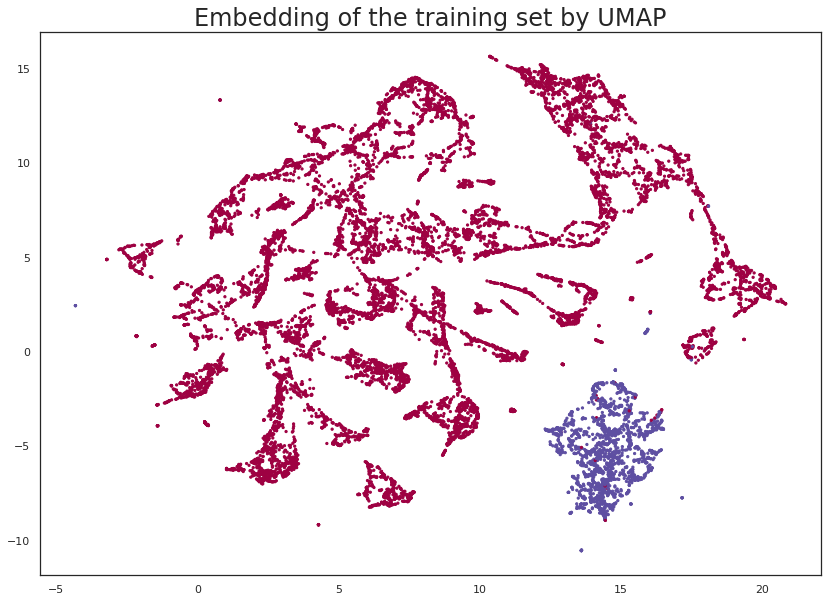

In [26]:
trans = umap.UMAP(n_neighbors=5, random_state=1).fit(X_train)
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 5, c=y_train, cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);

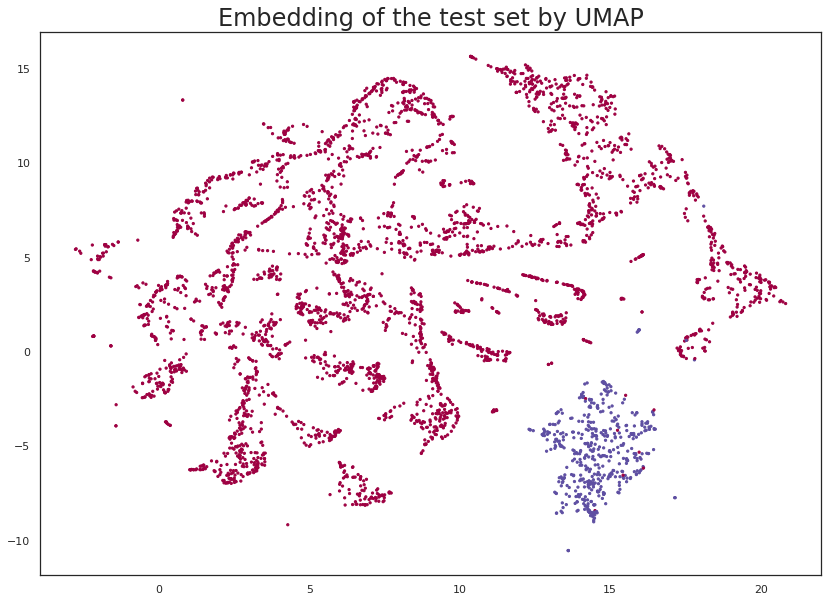

In [30]:
RF.fit(trans.embedding_,y_train)
test_embedding = trans.transform(X_test)
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 5, c=y_test, cmap='Spectral')
plt.title('Embedding of the test set by UMAP', fontsize=24);


In [31]:
y_predRF = RF.predict(test_embedding)
print(accuracy_score(y_test,y_predRF)) # Fraction of classifications that were correct
print(precision_score(y_test,y_predRF,pos_label=1))

0.9975804500362933
0.9874476987447699


In [37]:
%%time
toClassify_embedding = trans.transform(toClassify)
y_pred = RF.predict(toClassify_embedding)

CPU times: user 23min 4s, sys: 10.5 s, total: 23min 14s
Wall time: 23min 5s


In [46]:
toClassify['pred'] = y_pred
rslt_df = toClassify[toClassify['pred'] == 1]
rslt_df.sample(n=100, random_state=1).index.values

array([234955151, 427395763, 231151358, 232502812, 388181972,  34508914,
       153546202, 438500197, 156189781, 389362972, 124193640, 276662581,
       247528226, 206730379, 278863994,  34507632, 124198462, 220053779,
        34264276, 142017565, 124190966, 156426150,  24775022, 427394259,
       301391101, 251164944, 299586399, 260303970, 237807367, 264742463,
       427353040, 301600664,  36439717,  59773079, 436243810,  11965059,
       385910441, 220316713, 318059999,  31144448, 257064676, 124491772,
       293929067, 713473796, 172463638, 271998864,  42467705, 266072835,
       415558845, 151106152,  50588543,  14220608, 263338018, 350430071,
       123835580,  39347476,  72921630, 200640175, 220115262,  30030988,
       234824314, 172927063, 282806890, 251134159, 293776750,  91928470,
       436429331,  48955579, 281905650,  20071178,  53156870, 140861399,
       280867759,  48232944, 389246917,  66655054, 279092844, 237641831,
       437960821, 427347890, 299941385, 148183407, 

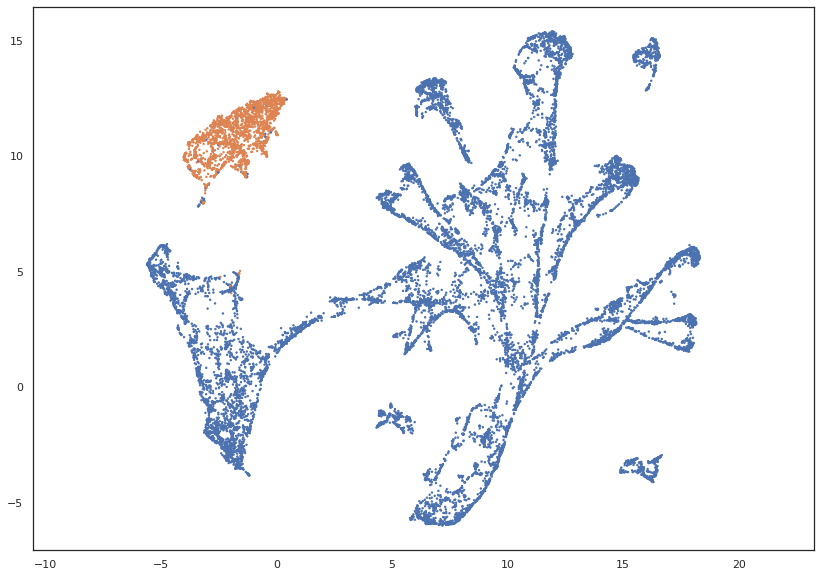

In [25]:
embedding = reducer.fit_transform(X_train)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=2,
    c=[sns.color_palette()[x] for x in y_train.map({0:0, 1:1 })])
plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection of the stars', fontsize=24)

__________
This assumes that astats is already in the datafile, and can be imported along with the other features

In [47]:
#sector you want to classify
sector = 6

In [48]:
#create the directory for each sector
os.mkdir(f'Sector{sector}')

FileExistsError: [Errno 17] File exists: 'Sector6'

In [49]:
#change the variable toClassify to data that you want to classify
toClassify = pd.read_hdf(datafile, f'S{sector}/features')
refsect = pd.read_csv(data_dir+f"sector{sector}lookup.csv")

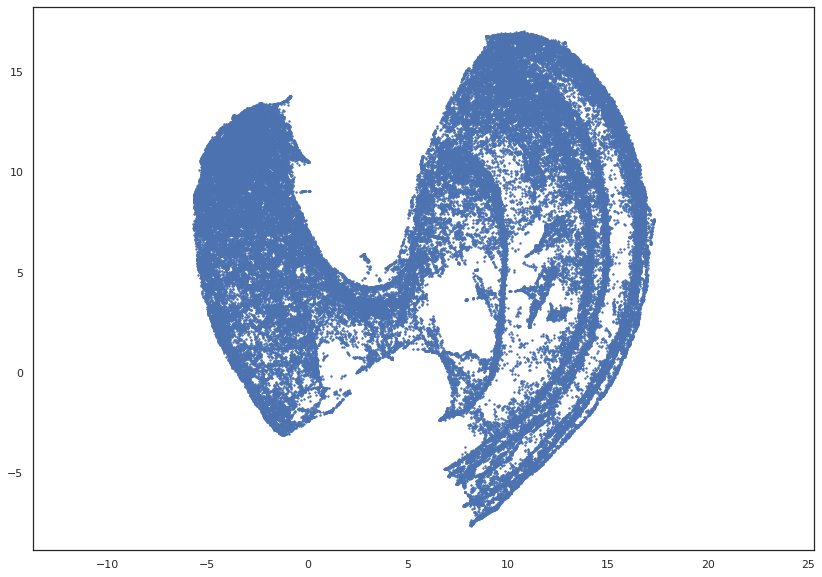

In [51]:
embedding = reducer.fit_transform(toClassify.sample(100000))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=2,
    )
plt.gca().set_aspect('equal', 'datalim')

In [26]:
y_pred = RF.predict(toClassify)
#rslt_df.to_csv(f'Sector{sector}/predSector{sector}.csv')

In [27]:
y_predprob = RF.predict_proba(toClassify)

In [28]:
y_predprob

array([[1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       ...,
       [1.   , 0.   ],
       [0.996, 0.004],
       [1.   , 0.   ]])

In [31]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
#y_probzero = prediction confidence probability of zero
#y_probone = prediction confidence probability of one
y_probzero = []
y_probone = []
for i in range(len(y_predprob)):
    y_probzero.append(y_predprob[i][0])
    y_probone.append(y_predprob[i][1])

In [29]:
toClassify['pred'] = y_pred
toClassify['probzero'] = y_probzero
toClassify['probone'] = y_probone
rslt_df = toClassify[toClassify['pred'] == 1]

In [31]:
d = {'pred' : y_pred, 'probzero' : y_probzero, 'probone' : y_probone}
CV = pd.DataFrame(data = d)
CV.to_csv('Sector6/CV.csv')

In [36]:
toClassify

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat,probzero,probone
251269189,0.000269,0.999981,7.222776e-08,0.000269,242.0,0.0,5.0,5.0,0.000153,0.008087,...,0.260853,0.378293,0.536652,0.765845,0.002046,0.534761,0.487,0.101711,1.000,0.000
11199201,0.000340,1.000012,1.157584e-07,0.000340,301.0,1.0,0.0,1.0,0.000230,0.013218,...,0.263026,0.407784,0.566966,0.763643,0.001540,0.996224,-0.094,0.289609,1.000,0.000
11197342,0.000355,1.000025,1.257538e-07,0.000355,287.0,0.0,0.0,0.0,0.000218,0.009656,...,0.265304,0.384835,0.534202,0.795165,0.001338,0.776569,-0.238,0.395487,1.000,0.000
234271852,0.002851,0.999978,8.128245e-06,0.002851,260.0,0.0,1.0,1.0,0.001765,0.142535,...,0.290101,0.415781,0.578310,0.784964,0.033248,0.714904,0.104,0.229952,1.000,0.000
237736917,0.001683,1.000044,2.831918e-06,0.001683,291.0,1.0,0.0,1.0,0.001107,0.077765,...,0.269580,0.396938,0.561477,0.785257,0.009305,1.231992,-0.166,0.044972,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306910194,0.002299,0.999605,5.285637e-06,0.002300,183.0,1.0,7.0,8.0,0.001228,0.028972,...,0.322091,0.426980,0.553811,0.802176,0.017737,0.812900,0.612,0.226680,1.000,0.000
306808426,0.001467,0.999996,2.152518e-06,0.001467,248.0,4.0,0.0,4.0,0.000953,0.016892,...,0.280043,0.447909,0.600444,0.766037,0.012969,2.198081,-0.096,0.305667,1.000,0.000
306911868,0.001238,0.999867,1.532303e-06,0.001238,327.0,0.0,0.0,0.0,0.000926,0.012549,...,0.334588,0.467407,0.628315,0.809456,0.003785,0.477304,0.199,0.241496,1.000,0.000
306912997,0.001271,1.000168,1.615076e-06,0.001271,213.0,2.0,0.0,2.0,0.000576,0.014940,...,0.178888,0.291748,0.418907,0.627517,0.008711,1.379476,-0.288,0.296004,0.996,0.004


In [66]:
txt_file = open("data/EBs_noYifan_sector6.txt", "r")
file_content = txt_file.read()
content_list = file_content.split("\n")
txt_file.close()
falseneglist = [eval(i) for i in content_list]

falseneglist

[235302840,
 291385340,
 151467181,
 100682876,
 72782194,
 61399839,
 61587373,
 61587383,
 237652393,
 237744078,
 42819010,
 437956145,
 434400399,
 119553244,
 36995455,
 97642729,
 25248826,
 220113180,
 220113185,
 717187734,
 717187735,
 202015589,
 307021664,
 307021665,
 237816806,
 266005231,
 711834166,
 279902112,
 762634460,
 91870711,
 91870715,
 91870721,
 237742115,
 434403321,
 250589534,
 263694657,
 263694668,
 63043258,
 168195898,
 282304507,
 53176760,
 231347373,
 250470383,
 282607438,
 282607443,
 36998354,
 438490744,
 319730823,
 167119003,
 291332565,
 97643944,
 199886262,
 237667069,
 263805896,
 53421164,
 235449761,
 237613397,
 237635393,
 301775577,
 427394717,
 427394721,
 427394732,
 333140513,
 386267565,
 120327872,
 438193125,
 30313695,
 282303787,
 36438546,
 167307525,
 280297598,
 207019236,
 234256682,
 237816792,
 386045551,
 206858968,
 151281308,
 237422089,
 281413326,
 317333116,
 124096035,
 143105037,
 220212798,
 234270718,
 237426004

In [68]:
falseneg = toClassify[toClassify.index.isin(falseneglist)]

In [69]:
rslt_df = toClassify[toClassify['pred'] == 1]

In [70]:
rslt_df

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat,pred,probzero,probone
141126559,0.129283,0.966157,0.016714,0.133812,225.0,0.0,1.0,1.0,0.078338,1.612755,...,0.382946,0.535229,0.865685,0.966863,0.332072,0.809,0.866650,1,0.4535,0.5465
31303242,0.071903,0.982412,0.005170,0.073190,58.0,0.0,22.0,22.0,0.000670,0.214146,...,0.008720,0.011854,0.017514,0.998374,0.007386,1.206,0.673295,1,0.0680,0.9320
260161144,0.066176,0.978258,0.004379,0.067647,97.0,0.0,1.0,1.0,0.000965,0.448632,...,0.010310,0.022724,0.484134,0.998295,0.010259,1.435,0.850411,1,0.0000,1.0000
156241056,0.070821,0.972317,0.005016,0.072837,112.0,0.0,0.0,0.0,0.002759,0.628637,...,0.025548,0.119360,0.613303,0.305047,0.067491,1.550,0.875323,1,0.0000,1.0000
309908721,0.029504,0.988698,0.000871,0.029842,118.0,0.0,0.0,0.0,0.001948,0.206244,...,0.044064,0.140639,0.617406,0.114579,0.396873,1.458,0.691977,1,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250470344,0.026891,0.991369,0.000723,0.027125,89.0,0.0,19.0,19.0,0.001047,0.109420,...,0.026788,0.049050,0.398950,0.154673,0.023941,1.480,0.707522,1,0.0000,1.0000
220420534,0.046102,0.987261,0.002125,0.046696,78.0,0.0,1.0,1.0,0.003164,0.226328,...,0.069424,0.185201,0.418781,0.999090,0.079798,1.097,0.696240,1,0.4940,0.5060
33716637,0.071296,0.971362,0.005083,0.073398,105.0,0.0,1.0,1.0,0.015595,0.396347,...,0.247192,0.397989,0.628234,0.997895,0.113634,1.258,0.850790,1,0.0180,0.9820
251258191,0.025978,0.992660,0.000675,0.026171,71.0,0.0,26.0,26.0,0.000588,0.072821,...,0.015233,0.022041,0.049144,0.135237,0.020763,1.469,0.755226,1,0.0020,0.9980


In [71]:
falseneg.to_csv(f'Sector{sector}/falseNegSector{sector}.csv')
rslt_df.to_csv(f'Sector{sector}/pred&confidenceValsSector{sector}.csv')

In [73]:
txt_file = open("data/periodicvariables.txt", "r")
file_content = txt_file.read()
content_list = file_content.split("\n")
txt_file.close()
pv = [eval(i) for i in content_list]

pv

[151290873,
 150167319,
 46430860,
 219389540,
 148466573,
 31406847,
 34509850,
 142018697,
 364424408,
 271551109,
 59848003,
 235058181,
 255590987,
 350584820,
 30317282,
 279572957,
 157076761,
 24401034,
 59277801,
 301184144,
 242133922,
 219380615,
 156886111,
 200368439,
 52111781,
 167550778,
 247752676,
 11201263,
 302491052,
 59546592,
 52001055,
 443052860,
 287638537,
 61499909,
 157460439,
 156194175,
 156194180,
 279323744,
 167815117,
 270677813,
 231720407,
 147948928,
 78055893,
 100479167,
 31281820,
 119020352,
 238194430,
 167207809,
 124251608,
 706185962,
 706185961,
 167324989,
 32600963,
 148466457,
 156921008,
 134227131,
 24824554,
 32707063,
 61246632,
 37735962,
 30948085,
 264621259]

In [74]:
periodvar = toClassify[toClassify.index.isin(pv)]
periodvar.to_csv(f'Sector{sector}/pervarSector{sector}.csv')

___

In [17]:
rslt_df = pd.read_csv(f'Sector{sector}/pred&confidenceValsSector{sector}.csv', index_col = 0)
rslt_df

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat,pred,probzero,probone
141126559,0.129283,0.966157,0.016714,0.133812,225.0,0.0,1.0,1.0,0.078338,1.612755,...,0.382946,0.535229,0.865685,0.966863,0.332072,0.809,0.866650,1,0.4535,0.5465
31303242,0.071903,0.982412,0.005170,0.073190,58.0,0.0,22.0,22.0,0.000670,0.214146,...,0.008720,0.011854,0.017514,0.998374,0.007386,1.206,0.673295,1,0.0680,0.9320
260161144,0.066176,0.978258,0.004379,0.067647,97.0,0.0,1.0,1.0,0.000965,0.448632,...,0.010310,0.022724,0.484134,0.998295,0.010259,1.435,0.850411,1,0.0000,1.0000
156241056,0.070821,0.972317,0.005016,0.072837,112.0,0.0,0.0,0.0,0.002759,0.628637,...,0.025548,0.119360,0.613303,0.305047,0.067491,1.550,0.875323,1,0.0000,1.0000
309908721,0.029504,0.988698,0.000871,0.029842,118.0,0.0,0.0,0.0,0.001948,0.206244,...,0.044064,0.140639,0.617406,0.114579,0.396873,1.458,0.691977,1,0.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250470344,0.026891,0.991369,0.000723,0.027125,89.0,0.0,19.0,19.0,0.001047,0.109420,...,0.026788,0.049050,0.398950,0.154673,0.023941,1.480,0.707522,1,0.0000,1.0000
220420534,0.046102,0.987261,0.002125,0.046696,78.0,0.0,1.0,1.0,0.003164,0.226328,...,0.069424,0.185201,0.418781,0.999090,0.079798,1.097,0.696240,1,0.4940,0.5060
33716637,0.071296,0.971362,0.005083,0.073398,105.0,0.0,1.0,1.0,0.015595,0.396347,...,0.247192,0.397989,0.628234,0.997895,0.113634,1.258,0.850790,1,0.0180,0.9820
251258191,0.025978,0.992660,0.000675,0.026171,71.0,0.0,26.0,26.0,0.000588,0.072821,...,0.015233,0.022041,0.049144,0.135237,0.020763,1.469,0.755226,1,0.0020,0.9980


In [29]:
rslt_df[rslt_df['probzero'] > 0.47]

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat,pred,probzero,probone
12165310,0.043921,0.992704,0.001929,0.044244,99.0,0.0,19.0,19.0,0.003465,0.049369,...,0.042339,0.102759,0.205695,0.219697,0.483949,0.840,0.126358,1,0.496000,0.504000
443414640,0.061649,0.988430,0.003801,0.062370,50.0,0.0,17.0,17.0,0.006684,0.305853,...,0.149180,0.196998,0.262645,0.990585,0.043162,0.929,0.637310,1,0.486000,0.514000
97566657,0.023462,0.994752,0.000550,0.023586,47.0,0.0,29.0,29.0,0.000226,0.039600,...,0.013767,0.019685,0.029313,0.131289,0.066281,1.108,0.461836,1,0.482000,0.518000
306362985,0.089086,0.967666,0.007936,0.092062,136.0,0.0,1.0,1.0,0.041008,1.384837,...,0.384132,0.495469,0.735080,0.986391,0.198252,1.027,0.904761,1,0.476500,0.523500
36549459,0.010322,0.997866,0.000107,0.010344,45.0,0.0,25.0,25.0,0.000496,0.053593,...,0.082537,0.114629,0.169793,0.068161,0.155630,1.033,0.498486,1,0.494000,0.506000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220238893,0.010285,0.998113,0.000106,0.010305,100.0,0.0,15.0,15.0,0.003043,0.096945,...,0.167292,0.230189,0.370752,0.056638,0.192169,0.946,0.794351,1,0.488000,0.512000
220315618,0.013298,0.997197,0.000177,0.013335,46.0,0.0,24.0,24.0,0.002040,0.098213,...,0.204978,0.277073,0.390985,0.082963,0.092369,1.006,0.765290,1,0.472333,0.527667
231205005,0.004044,0.999208,0.000016,0.004047,74.0,0.0,23.0,23.0,0.000873,0.026776,...,0.138922,0.204060,0.294267,0.022406,0.482723,0.739,0.273627,1,0.492000,0.508000
259699534,0.051411,0.984428,0.002643,0.052224,91.0,0.0,1.0,1.0,0.013931,0.285589,...,0.239174,0.322457,0.568359,0.993727,0.144991,1.082,0.860980,1,0.475000,0.525000


In [30]:
rslt_df[rslt_df['probzero'] > 0.47].index.values

array([ 12165310, 443414640,  97566657, 306362985,  36549459, 202057643,
       282270730,  51834509,  93128995, 282393297, 167178953, 200341207,
       220420532, 250462213, 155450553, 436098466,  36549461, 438325776,
       372475743, 229336937, 270714932, 231236716, 220224459, 127233332,
        32539043, 124500156, 124776014, 269279959, 287355511, 157573720,
        37396447,  36440147, 251165368, 250573491,  47632623,  59617313,
       234879731, 438500539, 717425538, 102452605,  48951945, 300707137,
       220077375,  43152097, 167339240, 339672935, 336882813, 229205551,
       299586513, 200546736, 232178820, 232518595, 232191981, 250470331,
        36288097,  39352882,  52420727, 127106464, 202007782, 237491373,
       317599919, 120664175, 287429535,  52417598, 238090350, 255685600,
       282607438, 280222813, 715405694, 427497933,  32595887, 220144004,
       714452405, 153708335, 257065278, 282583964, 232280036,  20209072,
       237816348, 237400810,  36210679, 241914912, 

In [25]:
toClassify

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat
251269189,0.000269,0.999981,7.222776e-08,0.000269,242.0,0.0,5.0,5.0,0.000153,0.008087,...,0.474194,0.157313,0.260853,0.378293,0.536652,0.765845,0.002046,0.534761,0.487,0.101711
11199201,0.000340,1.000012,1.157584e-07,0.000340,301.0,1.0,0.0,1.0,0.000230,0.013218,...,0.363347,0.151263,0.263026,0.407784,0.566966,0.763643,0.001540,0.996224,-0.094,0.289609
11197342,0.000355,1.000025,1.257538e-07,0.000355,287.0,0.0,0.0,0.0,0.000218,0.009656,...,0.400424,0.149555,0.265304,0.384835,0.534202,0.795165,0.001338,0.776569,-0.238,0.395487
234271852,0.002851,0.999978,8.128245e-06,0.002851,260.0,0.0,1.0,1.0,0.001765,0.142535,...,0.345161,0.170297,0.290101,0.415781,0.578310,0.784964,0.033248,0.714904,0.104,0.229952
237736917,0.001683,1.000044,2.831918e-06,0.001683,291.0,1.0,0.0,1.0,0.001107,0.077765,...,0.361290,0.140689,0.269580,0.396938,0.561477,0.785257,0.009305,1.231992,-0.166,0.044972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306910194,0.002299,0.999605,5.285637e-06,0.002300,183.0,1.0,7.0,8.0,0.001228,0.028972,...,0.462801,0.197064,0.322091,0.426980,0.553811,0.802176,0.017737,0.812900,0.612,0.226680
306808426,0.001467,0.999996,2.152518e-06,0.001467,248.0,4.0,0.0,4.0,0.000953,0.016892,...,0.352298,0.148443,0.280043,0.447909,0.600444,0.766037,0.012969,2.198081,-0.096,0.305667
306911868,0.001238,0.999867,1.532303e-06,0.001238,327.0,0.0,0.0,0.0,0.000926,0.012549,...,0.291028,0.198422,0.334588,0.467407,0.628315,0.809456,0.003785,0.477304,0.199,0.241496
306912997,0.001271,1.000168,1.615076e-06,0.001271,213.0,2.0,0.0,2.0,0.000576,0.014940,...,0.528446,0.090587,0.178888,0.291748,0.418907,0.627517,0.008711,1.379476,-0.288,0.296004


In [44]:
toClassify[(toClassify['probzero'] > 0.60)][(toClassify['probzero'] < 0.80)].index.values[:100]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


array([ 78568736, 291385340, 350478924, 231809798,  31118189, 263284321,
       160328766, 141975903,  49547177,  13345143,  12165310, 278826996,
       382067804, 260162199, 138857475, 322899250,  42889751, 276935987,
       229282662, 167303776, 279955276, 404854539, 141685465, 427398881,
        30313682, 370101492,  52910768, 237558971, 237702040, 199889776,
       438228316, 247560986, 142718336,  78056414,  78056415,  91866171,
       124777433, 151233402, 229163063, 206791096,  79140936,  63357400,
       380026900, 322816126, 156998635,  63039598, 255586667, 259574789,
       259589049, 291332565,  80839678,  37404443,  37248141, 172465372,
       206703819, 263272455, 233970058, 364537633,  32595021, 202057921,
        53324352,  53421164,  52906667,  97643621, 382044071,  78746287,
       269117184, 199886262,   7418959, 372655446, 237499890,  92010432,
       274235905, 229274555, 158819162, 234818672, 265908204, 199895357,
       220066690, 281716393, 235055647, 260298902, 

In [37]:
rslt_df[rslt_df['probzero'] == 0].index.values[:100]

array([260161144, 156241056, 309908721,  63192395, 144695651, 153166843,
       234211934, 141268467,  42991745, 300654002, 201497357, 231822771,
        33419790, 119461266,  42828781, 350443417, 350622185, 264594193,
        35481236, 281055015,  92009366,  36369488, 241992883, 281409893,
       306691906, 234876565, 437986153, 737425239,  59715570,  59715572,
        34508912, 438228173, 143350469,  33743771, 206840192, 291380703,
       167746516,  53588177, 235409189, 220200239, 153166064, 443052779,
        25126289, 220140809,  80603783, 220149256,  46623628, 247952100,
       124688144, 237647548, 257064676, 257064693, 257064029, 237465888,
       301185877, 307812314, 340979875,  24433067, 220205515, 220278771,
        43250275, 281897356, 250589512,  50744490,  36574983, 281494100,
        79781905, 158824564, 231921891, 124099758, 437938517, 438226468,
       134309817, 264483228, 233975504, 438124870, 151470826, 206763638,
       237753600, 234699871, 280431207, 231803612, 

____

In [76]:
#Testing
toClassify[toClassify['probone'] > 0.25]

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat,astat,pred,probzero,probone
141126559,0.129283,0.966157,0.016714,0.133812,225.0,0.0,1.0,1.0,0.078338,1.612755,...,0.382946,0.535229,0.865685,0.966863,0.332072,0.809,0.866650,1,0.453500,0.546500
31303242,0.071903,0.982412,0.005170,0.073190,58.0,0.0,22.0,22.0,0.000670,0.214146,...,0.008720,0.011854,0.017514,0.998374,0.007386,1.206,0.673295,1,0.068000,0.932000
50897998,0.002341,0.999006,0.000005,0.002343,162.0,0.0,0.0,0.0,0.000667,0.020193,...,0.289583,0.481719,0.605978,0.010015,0.205155,1.204,0.815128,0,0.502000,0.498000
11756637,0.058857,0.992608,0.003464,0.059295,47.0,0.0,21.0,21.0,0.010426,0.466799,...,0.312899,0.410307,0.552973,0.429933,0.141874,0.784,0.690770,0,0.616267,0.383733
78568736,0.053338,0.992674,0.002845,0.053732,32.0,0.0,11.0,11.0,0.002703,0.170517,...,0.275767,0.470794,0.753199,1.000000,0.088885,0.707,0.541922,0,0.714433,0.285567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220420534,0.046102,0.987261,0.002125,0.046696,78.0,0.0,1.0,1.0,0.003164,0.226328,...,0.069424,0.185201,0.418781,0.999090,0.079798,1.097,0.696240,1,0.494000,0.506000
33716637,0.071296,0.971362,0.005083,0.073398,105.0,0.0,1.0,1.0,0.015595,0.396347,...,0.247192,0.397989,0.628234,0.997895,0.113634,1.258,0.850790,1,0.018000,0.982000
251258191,0.025978,0.992660,0.000675,0.026171,71.0,0.0,26.0,26.0,0.000588,0.072821,...,0.015233,0.022041,0.049144,0.135237,0.020763,1.469,0.755226,1,0.002000,0.998000
34397579,0.129846,0.989043,0.016860,0.131284,148.0,5.0,0.0,5.0,0.021386,0.292172,...,0.086130,0.256070,0.460708,0.597429,0.752603,0.409,0.162228,0,0.610833,0.389167


___

In [84]:
type(rslt_df.index.values[0])

numpy.int64

In [97]:
a = agraph(34397579)
a

1

In [93]:
#rslt_df = pd.read_csv(f'predSector{sector}.csv', index_col = 0)
values = rslt_df.index.values
values = values.tolist()
with open(f"Sector{sector}/ticpredictionsSector{sector}.txt", "w") as output:
    for i in range(len(values)):
        output.write(str(values[i]))
        output.write("\n")

In [29]:
'''sample = rslt_df.sample(n = 100)
tics = sample.index.values
sect = []
camera = []
files = []
for i in tics[:100]:
    row = refsect[refsect['TIC_ID'] == i]
    sect.append(row.Sector.values[0])
    camera.append(row.Camera.values[0])
    files.append(data_dir + row.Filename.values[0])'''

,longtermtrend,meanmedrat,skews,varss,coeffvar,stds,numoutliers,numnegoutliers,numposoutliers,numout1s,...,magratio,sautocorrcoef,autocorrcoef,flatmean,tflatmean,roundmean,troundmean,roundrat,flatrat,mstat
172929247,0.000806,0.999978,6.501501e-07,0.000806,314.0,0.0,1.0,1.0,0.000543,0.042194,...,-0.472674,0.347656,0.160797,0.287203,0.412570,0.562537,0.781880,0.004166,0.612038,0.269
172192984,0.000742,1.000006,5.508504e-07,0.000742,145.0,3.0,3.0,6.0,0.000320,0.024576,...,-0.358598,0.473633,0.136615,0.251226,0.381969,0.529896,0.761778,0.010774,3.619774,0.304
172841094,0.002370,1.000015,5.615286e-06,0.002370,313.0,0.0,1.0,1.0,0.001580,0.120841,...,-0.496051,0.376953,0.143445,0.248281,0.404920,0.550767,0.754253,0.011706,0.691647,0.254
409735202,0.005957,1.001751,3.548214e-05,0.005946,346.0,0.0,0.0,0.0,0.003606,0.044751,...,-0.494486,0.333971,0.128034,0.277527,0.472880,0.645347,0.837067,0.017867,0.787477,-0.562
296651584,0.007936,1.000209,6.298619e-05,0.007935,295.0,4.0,0.0,4.0,0.005022,0.359427,...,-0.491522,0.405742,0.151142,0.278334,0.424020,0.582224,0.789453,0.051401,1.339483,-0.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80710138,0.001958,0.999947,3.833646e-06,0.001958,211.0,0.0,7.0,7.0,0.001097,0.108878,...,-0.860707,0.346680,0.167270,0.292615,0.419409,0.583147,0.756124,0.019518,0.536648,0.458
99508260,0.004796,1.000162,2.300333e-05,0.004795,378.0,0.0,0.0,0.0,0.003529,0.066485,...,0.633418,0.281250,0.172394,0.296617,0.445719,0.628671,0.837777,0.011922,0.621098,-0.090
5223004,0.000851,1.000003,7.237000e-07,0.000851,315.0,0.0,1.0,1.0,0.000564,0.042483,...,-0.494143,0.369260,0.163971,0.279948,0.410634,0.557732,0.772835,0.005229,0.673119,0.096
348598616,0.000965,0.999967,9.311109e-07,0.000965,310.0,0.0,0.0,0.0,0.000619,0.037272,...,-0.505192,0.397473,0.140693,0.254708,0.388299,0.543981,0.761431,0.003430,0.583605,0.205


___
Find equal-depth eclipsing binary systems

In [77]:
#rslt_df = pd.read_csv(f'predSector{sector}.csv', index_col = 0)
from data import autopeak as ap

In [94]:
ref = pd.read_csv(data_dir+"sector1lookup.csv")
ref.head()
sec = 6
ref = pd.read_csv(data_dir+f"sector{sec}lookup.csv")
tmcl = ["2_min_cadence" in fn for fn in ref.Filename]

In [95]:
import numpy as np
import matplotlib.pyplot as plt # plotting package
import matplotlib.cm as cm # colormaps
import scipy.signal
import scipy.ndimage.filters
import os
import sys
import fourier
from scipy.optimize import curve_fit
from astropy.io import ascii
from astropy.table import Table
import glob
import re
import pandas as pd

def fnoise(x, a, b, c):
 return a/(x+b)+c

def clean(sequence,n,p):
#Task to iteratively clean a sequence of outliers at the n-sigma level, smoothing every p points.

  smoothseq = scipy.signal.medfilt(sequence, p)
  resid = sequence-smoothseq

# Do iterative sigma clipping of points beyond n-sigma:
  oldstd = scipy.stats.nanstd(resid)
  good = np.where(abs(resid) < n*scipy.stats.nanstd(resid))
  good = good[0]
  newstd = scipy.stats.nanstd(resid[good])
  while (1.-newstd/oldstd > 0.02):
    good1 = np.where(abs(resid[good]) < n*newstd)
    good = good[good1[0]]
    oldstd = newstd
    newstd = scipy.stats.nanstd(resid[good])

  return good

#peak finding algorithm - in autocorrelation
def count(times,values,minamp):
  dtimes=[times[0]]
  zpoints=[values[0]]

  first=(np.where(np.abs(values-values[0]) > minamp))[0]

  if (len(first) != 0):
     dtimes = np.append(dtimes,times[first[0]])
     zpoints = np.append(zpoints,values[first[0]])

     flip=int(np.abs(zpoints[1]-zpoints[0])/(zpoints[1]-zpoints[0]))

     y0=zpoints[0]
     y1=zpoints[1]

     for i in np.arange(first[0]+1,len(times)):
        if (flip == 1):
         if ((values[i]-y0) > (y1-y0)):
           zpoints[len(zpoints)-1]=values[i]
           dtimes[len(zpoints)-1]=times[i]
           y1=values[i]

         if ((y1-values[i]) > minamp):
           zpoints = np.append(zpoints,values[i])
           dtimes = np.append(dtimes,times[i])
           y0=y1
           y1=values[i]
           flip=-1

        if (flip == -1):
         if ((y0-values[i]) > (y0-y1)):
           zpoints[len(zpoints)-1]=values[i]
           dtimes[len(zpoints)-1]=times[i]
           y1=values[i]

         if ((values[i]-y1) > minamp):
           zpoints=np.append(zpoints,values[i])
           dtimes=np.append(dtimes,times[i])
           y0=y1
           y1 = values[i]
           flip = 1

  result = np.array([dtimes,zpoints])

  return result

#use ticid for star
def autopeak(time,flux2,star,sector):

# remove 7-sigma outliers
  time = time[flux2>0]
  flux2 = flux2[flux2>0]
  avg = np.nanmedian(-2.5*np.log10(flux2))
  rms = np.nanstd(-2.5*np.log10(flux2))

  fine = np.where((abs(-2.5*np.log10(flux2)-avg) < 7.*rms) & (~np.isnan(flux2)))
  fine = fine[0]

  avg = np.median(-2.5*np.log10(flux2[fine]))
  rms = np.nanstd(-2.5*np.log10(flux2[fine]))

  mag = -2.5*np.log10(flux2[fine])

  #FIGURE THIS PART OUT  
  if fine.size==0:
    result = np.array([0,1,0,0,1,0])
    return result

# Interpolate onto evenly spaced grid...
  ndatapoints=7040.
  ndays=(time[fine])[len(time[fine])-1]-time[fine[0]]
  u=ndatapoints/ndays

  inttime=(np.arange(ndatapoints,dtype='float')/u)+(time[fine])[0]-(time[fine])[0]
  maginterp=np.interp(inttime,time[fine]-(time[fine])[0],mag)

#  Compute autocorrelation function:
  lag = np.arange(len(maginterp),dtype='float')
  unbias = maginterp-np.mean(maginterp)
  norm = np.sum(unbias**2)    

  ac = np.correlate(unbias,unbias, "full")/norm
  ac = ac[round(len(ac)/2)-1:]

  result=count(lag/u,ac,0.05)
  autopeaks = (result[1])[np.arange(round((len(result[0])+1)/2)-1)*2]
  autopeaktimes = (result[0])[np.arange(round((len(result[0])+1)/2)-1)*2]

  autopeaks = autopeaks[1:len(autopeaks)]
  autopeaktimes = autopeaktimes[1:len(autopeaktimes)]
  
  if (len(autopeaks)>=1):
    bigpeak=np.max(autopeaks)
    bigpeaklag = np.argmax(autopeaks)
    finalper = autopeaktimes[bigpeaklag]
  else:
    finalper = 0.00000000001

  #potential peaks in the autocorrelation functino (plots red dots if exist)
  periodicity = 0
  if (len(autopeaks) >= 1):
   acfit,accov = curve_fit(fnoise,lag/u,ac)
   acsmoothed = acfit[0]/(lag/u+acfit[1])+acfit[2]
   x= np.where(ac == bigpeak)
   x= x[0][0].item()
   peaksmooth = acsmoothed[x]
   periodicity = bigpeak - peaksmooth

   if (len(autopeaks) > 1):
        
  #use bigpeak, then fit slowly varying curve to the autocorrelation (ac)
     if (bigpeak > 1.5*np.max(autopeaks[0:2])):
       finper = finalper
       
     else:
       
       finper = 0
  
  try:  
    if (autopeaks[0]>autopeaks[1]):
        result = 1
    elif (autopeaks[0]<autopeaks[1]):
        result = 2
  except:
    result = 0
  return result

In [96]:
def agraph(tic, remove_outliers = 0):
    row = ref[ref.TIC_ID.isin([tic])]
    string = str(row.Sector)
    s = string.split(" ")
    files = data_dir + ref.Filename.values
    filepath = files[int(s[0])]
    lightc = loaders.load_lc(filepath)
    tic = ref.TIC_ID.values
    tic = tic[int(s[0])]
    sec = ref.Sector.values
    sec = sec[int(s[0])]
    a = autopeak(lightc.time.value,lightc.flux.value,tic,sec)
    #print(a)
    return a

def agraph2(tic, remove_outliers = 0):
    row = ref[ref.TIC_ID.isin([tic])]
    string = str(row.Sector)
    s = string.split(" ")
    files = data_dir + ref.Filename.values
    filepath = files[int(s[0])]
    lightc = loaders.load_lc(filepath)
    tic = ref.TIC_ID.values
    tic = tic[int(s[0])]
    sec = ref.Sector.values
    sec = sec[int(s[0])]
    a = autopeak2(lightc.time.value,lightc.flux.value,tic,sec)
    #print(a)
    return a

In [32]:
%%time
#repeat the below sections for as many lcs there are
classification1000 = []
for i in range(1000):
    a = agraph(rslt_df.index.values[i])
    classification1000.append(a)

CPU times: user 1min 46s, sys: 57.3 s, total: 2min 43s
Wall time: 2min 43s


In [33]:
%%time
classification2000 = []
for i in range(1000,2000):
    a = agraph(rslt_df.index.values[i])
    classification2000.append(a)

CPU times: user 1min 45s, sys: 56.2 s, total: 2min 42s
Wall time: 3min 21s


In [37]:
%%time
classification3000 = []
for i in range(2000,3000):
    a = agraph(rslt_df.index.values[i])
    classification3000.append(a)

CPU times: user 1min 42s, sys: 51 s, total: 2min 33s
Wall time: 2min 33s


In [35]:
%%time
classification4000 = []
for i in range(3000,4000):
    a = agraph(rslt_df.index.values[i])
    classification4000.append(a)

CPU times: user 2min 51s, sys: 1min 14s, total: 4min 6s
Wall time: 9min 24s


In [39]:
%%time
classification5000 = []
for i in range(4000,5000):
    a = agraph(rslt_df.index.values[i])
    classification5000.append(a)

CPU times: user 1min 42s, sys: 49.2 s, total: 2min 31s
Wall time: 3min 3s


In [41]:
%%time
classification6000 = []
for i in range(5000,6000):
    a = agraph(rslt_df.index.values[i])
    classification6000.append(a)

IndexError: index 5255 is out of bounds for axis 0 with size 5255

[2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 2,
 0,
 1,
 array([0, 1, 0, 0, 1, 0]),
 1,
 array([0, 1, 0, 0, 1, 0]),
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,


In [42]:
#add them all into one list
#classification = classification500 + classification1000
classification = classification1000 + classification2000 + classification3000 + classification4000 + classification5000 + classification6000

In [94]:
#saves the prediction (1 or 2 or 0) in a txt file
with open(f"Sector{sector}/classificationSector{sector}.txt", "w") as output:
        output.write(str(classification))

In [45]:
d = {'TIC_ID' : rslt_df.index.values , 'Prediction': classification}
prediction = pd.DataFrame(data = d)

In [95]:
prediction.to_csv(f"Sector{sector}/classificationSect{sector}.csv", index=False)
index = prediction[prediction.Prediction.isin([1])]
index

,TIC_ID,Prediction
1,263074592,1
3,261656371,1
6,139721086,1
8,214198381,1
14,441406061,1
...,...,...
5243,149160359,1
5245,370239669,1
5247,2026963422,1
5248,734511288,1


In [48]:
#tic id of "same dip ebs" with estimated around 50% accuracy
tics = []
for i in index.index.values:
    tics.append(rslt_df.index.values[i])

In [97]:
with open(f"Sector{sector}/samedipebsSect{sector}.txt", "w") as output:
    for i in range(len(tics)):
        output.write(str(tics[i]))
        output.write("\n")

________
Phasing and saving the samedipebs

In [53]:
os.mkdir(f'TESSpklFilesSect{sector}')

In [53]:
sec = 1

In [55]:
def calcfold(tic,sec):
    row = ref[ref.TIC_ID.isin([tic])]
    string = str(row.Sector)
    s = string.split(" ")
    files = data_dir + ref.Filename.values
    filepath = files[int(s[0])]
    lightc = loaders.load_lc(filepath)
    period, phased = pf.calcfold(lightc,sec)
    obj = []
    obj.append(tic)
    obj.append(sec)
    obj.append(period.value)
    obj.append(phased.time.value)
    obj.append(phased.flux.value)
    obj.append(phased.flux_err.value)
    obj.append(phased.time_original.value)
    obj.append(phased.quality.value)
    output = open(f'TESSpklFilesSect{sec}/tesslc_{tic}folded.pkl', 'wb')
    pickle.dump(obj, output)
    output.close()

In [51]:
with open(f'Sector{sector}/samedipebsSect{sector}.txt') as f:
    tics = []
    for readline in f: 
        line_strip = readline.strip()
        tics.append(int(line_strip))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
for i in range(0,250):
    calcfold(tics[i],sec)

In [57]:
%%time
for i in range(250,500):
    calcfold(tics[i],sec)

CPU times: user 13min 21s, sys: 18.4 s, total: 13min 39s
Wall time: 13min 39s


In [72]:
#there seems to be some light kurves that are definitely not ebs, as they are centered around zero (for ex. check out TIC309853236(tics[565]) and TIC212259834(tics[711]))
#we can manually remove this later through visual parsing

In [59]:
%%time
for i in range(500,750):
    calcfold(tics[i],sec)
    print(i)

500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564


/opt/conda/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=1.01e+02 +/- 7.73e+02); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,
/opt/conda/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=1.01e+02 +/- 7.73e+02); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,


565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710


/opt/conda/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=4.25e+01 +/- 1.90e+02); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,
/opt/conda/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=4.25e+01 +/- 1.90e+02); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,


711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
CPU times: user 13min 31s, sys: 17.2 s, total: 13min 48s
Wall time: 13min 48s


In [83]:
len(tics)

1935

In [75]:
%%time
for i in range(750,1000):
    calcfold(tics[i],sec)

CPU times: user 13min 59s, sys: 17.7 s, total: 14min 17s
Wall time: 14min 17s


In [77]:
%%time
for i in range(1000,1250):
    calcfold(tics[i],sec)

CPU times: user 14min 13s, sys: 17.3 s, total: 14min 30s
Wall time: 14min 31s


In [78]:
%%time
for i in range(1250,1500):
    calcfold(tics[i],sec)

CPU times: user 14min 6s, sys: 17 s, total: 14min 23s
Wall time: 14min 23s


In [81]:
%%time
for i in range(1500,1750):
    calcfold(tics[i],sec)

CPU times: user 13min 44s, sys: 17.3 s, total: 14min 1s
Wall time: 14min 1s


In [82]:
%%time
for i in range(1750,2000):
    calcfold(tics[i],sec)

IndexError: list index out of range

____
Finding and removing closest stars, then printing the remaining light curves into a pdf file to visually examine

In [99]:
with open(f'Sector{sector}/ticpredictionsSector{sector}.txt') as f:
    tics = []
    for readline in f: 
        line_strip = readline.strip()
        tics.append(int(line_strip))

In [100]:
with open(f'Sector{sector}/samedipebsSect{sector}.txt') as f:
    tics2 = []
    for readline in f: 
        line_strip = readline.strip()
        tics2.append(int(line_strip))

In [101]:
nottics2 = []
for element in tics:
    if element not in tics2:
        nottics2.append(element)

In [102]:
stars = ref.TIC_ID.isin(tics)

In [104]:
#ref7335.csv - csv file for all ebs found
ref[stars].to_csv(f"Sector{sector}/refSect{sector}.csv")

In [105]:
closestarslist = []
for i in range(len(tics)):
    rastar = ref[stars].RA.values[i]
    decstar = ref[stars].Dec.values[i]
    dist = np.sqrt(((rastar-ref[stars].RA.values)*(np.cos(decstar)))**2+(decstar-ref[stars].Dec.values)**2)
    closestars = np.where((dist < 0.1) & (dist != 0))
    closestarslist.append(closestars)

In [128]:
closestarslist

[(array([], dtype=int64),),
 (array([ 396, 1728, 2313]),),
 (array([], dtype=int64),),
 (array([807]),),
 (array([1811]),),
 (array([ 406,  812, 1817]),),
 (array([402]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([ 848, 1870]),),
 (array([], dtype=int64),),
 (array([1883]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([1933, 1934, 1945]),),
 (array([], dtype=int64),),
 (array([1964]),),
 (array([ 424, 1966, 2003]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([444]),),
 (array([ 918,  919, 5215]),),
 (array([], dtype=int64),),
 (array([2177]),),
 (array([], dtype=int64),),
 (array([2242]),),
 (array([2264]),),
 (array([], dtype=int64),),
 (array([ 484, 2273]),),
 (array([], dtype=int64),),
 (array([1005]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([2298]),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 

In [116]:
closestarstics = []
for i in range (len(closestarslist)):
    tics = []
    tics.append(ref[stars].TIC_ID.values[i])
    for j in range(len(closestarslist[i][0])):
        tics.append(ref[stars].TIC_ID.values[closestarslist[i][0][j]])
    closestarstics.append(tics)

In [129]:
closestarstics

[[269762258],
 [263074592, 263074589, 612155681, 263074593],
 [278706358],
 [261656371, 261656369],
 [152825521, 152825523],
 [139699256, 2026930048, 139699260, 139699248],
 [139721086, 139721085],
 [139841210],
 [214198381],
 [144462697],
 [389726435, 389726434, 389726433],
 [160036449],
 [229057817, 229056112],
 [204497617],
 [441406061],
 [152223725],
 [25226885, 25226877, 25226886, 25200625],
 [280052690],
 [358457398, 299835005],
 [141268467, 141268468, 141268471, 141268474],
 [33862174],
 [267263253],
 [79403459, 79403456],
 [79225651, 79225639, 79225655, 1989169801],
 [394585218],
 [99465976, 99465986],
 [201176965],
 [389476160, 389476161],
 [261746657, 261748317],
 [262958558],
 [290547036, 290547040, 290547046],
 [263078276],
 [33715938, 33715940],
 [303909865],
 [181233908],
 [271596290, 271596289],
 [325469795],
 [220474209],
 [278683641],
 [201256771, 201256776],
 [92352621, 92352620],
 [92352620, 92352621],
 [441422220],
 [89398867],
 [147083089],
 [206462116, 2028782097,

In [110]:
#get lcs for ebs in the larger list thats not in smaller(same depth dip) eb list
refebs = ref.loc[ref['TIC_ID'].isin(nottics2)]
files = data_dir + ref.Filename.values
files = data_dir + refebs.Filename.values
filepath = files[0]
lcc = loaders.LightCurveCollection(refebs.Sector.values,
                                   refebs.Camera.values,
                                   files,
                                   False
                            )
lcc.useCpus = 8
lcc.load_all_lcs()

lcs = lcc.lcs

In [130]:
files2 = os.path.join(f'TESSpklFilesSect{sector}', 'tesslc_*.pkl')
files2 = glob.glob(files2)

In [131]:
#get folded lcs for smaller list
folded = []
for i in range(len(files2)):
    with (open(files2[i], "rb")) as openfile:
        while True:
            try:
                folded.append(pickle.load(openfile))
            except EOFError:
                break

In [132]:
tic = []
avgflux = []
for i in range(len(folded)):
    tic.append(folded[i][0])
    avgflux.append(np.median(folded[i][4]))
    
for i in range(len(lcs)):
    tic.append(nottics2[i])
    avgflux.append(np.median(lcs[i].flux.value))

In [133]:
d = {'TIC': tic, 'avgflux': avgflux}
avg = pd.DataFrame(d)

In [134]:
avg

,TIC,avgflux
0,238188289,3874.810425
1,290132590,658.987889
2,349835414,360.707860
3,300934001,226.355327
4,349788473,222.661370
...,...,...
5250,630986911,188630.783835
5251,278861826,10458.540525
5252,53951580,21058.399692
5253,309853072,14305.984937


In [135]:
highestfluxtics = []
for i in range(len(closestarstics)):
    a = []
    for j in closestarstics[i]:
        a.append(avg[avg['TIC'] == j].avgflux.values[0])
    highestfluxtics.append(closestarstics[i][a.index(max(a))])

In [136]:
highestfluxtics

[269762258,
 263074592,
 278706358,
 261656371,
 152825521,
 139699256,
 139721085,
 139841210,
 214198381,
 144462697,
 389726435,
 160036449,
 229057817,
 204497617,
 441406061,
 152223725,
 25226886,
 280052690,
 358457398,
 141268467,
 33862174,
 267263253,
 79403459,
 79225651,
 394585218,
 99465976,
 201176965,
 389476160,
 261746657,
 262958558,
 290547036,
 263078276,
 33715938,
 303909865,
 181233908,
 271596290,
 325469795,
 220474209,
 278683641,
 201256776,
 92352621,
 92352621,
 441422220,
 89398867,
 147083089,
 206462116,
 117544915,
 139148070,
 139207681,
 91369561,
 44623916,
 144194307,
 126944775,
 126945917,
 167692429,
 410354930,
 32200310,
 290131778,
 281498280,
 220521199,
 234491752,
 38586438,
 55652788,
 349832824,
 147131974,
 91448148,
 147201138,
 121420805,
 89018905,
 126602778,
 141606986,
 197766143,
 266996791,
 403136932,
 219308281,
 206505572,
 260161144,
 403153647,
 265591866,
 219338651,
 231714759,
 419635446,
 290025724,
 54001270,
 44135567

In [137]:
def checkIfDuplicates_2(listOfElems):
    ''' Check if given list contains any duplicates '''    
    setOfElems = set()
    for elem in listOfElems:
        if elem in setOfElems:
            return True
        else:
            setOfElems.add(elem)         
    return False

In [138]:
result = checkIfDuplicates_2(highestfluxtics)
if result:
    print('Yes, list contains duplicates')
else:
    print('No duplicates found in list')   

Yes, list contains duplicates


In [139]:
newlist = [] #eb list with no duplicates, cut down from 3345 to be ones with highest flux values in a radius of 0.1
duplist = []
for i in highestfluxtics:
    if i not in newlist:
        newlist.append(i)
    else:
        duplist.append(i)

In [140]:
with open(f"Sector{sector}/newlistSect{sector}.txt", "w") as output:
    for i in range(len(newlist)):
        output.write(str(newlist[i]))
        output.write("\n")

In [141]:
list1 = []
for element in newlist:
    if element in tics2:
        list1.append(element)

In [142]:
folded2 = []
for i in range(len(list1)):
    with (open(f'TESSpklFilesSect{sector}/tesslc_{list1[i]}folded.pkl', "rb")) as openfile:
        while True:
            try:
                folded2.append(pickle.load(openfile))
            except EOFError:
                break

In [143]:
import matplotlib.pyplot as plt

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(f"Sector{sector}/finallcsSect{sector}.pdf") as pdf:
    plt.cla()
    for i in range(len(folded2)):
        fig,ax = plt.subplots(2)
        lc = lk.LightCurve(time = folded2[i][3], flux = folded2[i][4], flux_err = folded2[i][5], targetid=folded2[i][0], quality = folded2[i][7])
        lc2.scatter(ax = ax[0])
        lc.remove_outliers(sigma_lower = 7, sigma_upper = 3).scatter(ax = ax[1])
        plt.title(f'TIC{folded2[i][0]}')
        pdf.savefig()
        plt.close();
plt.close()